In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
from glob import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.distributed as dist
from torchvision import datasets
import wandb

from ddbm import dist_util, logger
from datasets import load_data
from ddbm.resample import create_named_schedule_sampler
from ddbm.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    sample_defaults,
    args_to_dict,
    add_dict_to_argparser,
    get_workdir
)
from ddbm.train_util import TrainLoop

from datasets import InfiniteBatchSampler
from datasets.augment import AugmentPipe

## Data

In [3]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from dataclasses import dataclass
from torchvision import transforms as tr
from PIL import Image
import random

In [4]:
def get_channel_statistics(dataset):
    """
    Function for obtaining channel statistics (mean and deviation) for a dataset
    """
    channel_sum = np.zeros(3)
    channel_sq_sum = np.zeros(3)

    num_pixels = 0

    for img in tqdm(dataset):
        img = np.array(img) / 255.0
        channel_sum += img.mean(axis=(0, 1))
        channel_sq_sum += (img**2).mean(axis=(0, 1))
        num_pixels += 1

    channel_mean = channel_sum / num_pixels
    channel_std = np.sqrt(channel_sq_sum/num_pixels - channel_mean**2)

    return channel_mean, channel_std


def get_transforms(mean, std, img_size=256):
    train_transform = tr.Compose([
        tr.ToPILImage(),
        tr.Resize(img_size),
        tr.ToTensor(),
        tr.Normalize(mean, std)
    ])

    test_transform = tr.Compose([
        tr.ToPILImage(),
        tr.Resize(img_size),
        tr.ToTensor(),
        tr.Normalize(mean, std)
    ])
    
    def de_normalize(tensor, normalized=True):
        tmp = tensor.cpu() * torch.from_numpy(std).reshape(3,1,1) + torch.from_numpy(mean).reshape(3,1,1)
        return tmp.permute(1, 2, 0)
    
    return train_transform, test_transform, de_normalize


def flip(img):
    if isinstance(img, torch.Tensor):
        return img.flip(-1)
    return img.transpose(Image.FLIP_LEFT_RIGHT)


class ImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode=None):
        """
        mode: one of "a", "b", None
        """
        super().__init__()
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)]
        self.transform = transform
        self.mode = mode

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = cv2.imread(img_path)[:, :, ::-1]  # Convert BGR to RGB
        if self.mode == "a":
            image = image[:, :image.shape[1]//2, :]
        elif self.mode == "b":
            image = image[:, image.shape[1]//2:, :]
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.image_paths)


class PairedDataset(Dataset):
    def __init__(self, root_dir, transform_a=None, transform_b=None, random_flip=False):
        super().__init__()
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)]
        self.transform_a = transform_a
        self.transform_b = transform_b
        self.random_flip = random_flip

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = cv2.imread(img_path)[:, :, ::-1]  # Convert BGR to RGB
        image_a = image[:, :image.shape[1]//2, :]
        image_b = image[:, image.shape[1]//2:, :]
        if self.transform_a:
            image_a = self.transform_a(image_a)
        if self.transform_b:
            image_b = self.transform_b(image_b)
        
        if self.random_flip and random.random() < 0.5:
            image_a = flip(image_a)
            image_b = flip(image_b)

        return image_a, image_b, index  # index is needed for sampling

    def __len__(self):
        return len(self.image_paths)


@dataclass
class ImagesDatasetsClass:
    train_a: PairedDataset
    train_b: PairedDataset
    val_a: PairedDataset
    val_b: PairedDataset

@dataclass
class PairedDatasetsClass:
    train: PairedDataset
    val: PairedDataset

In [5]:
def load_data(
    data_dir,
    dataset,
    batch_size,
    image_size,
    deterministic=False,
    include_test=False,
    seed=42,
    num_workers=2,
):
    target_dir = os.path.join(data_dir, dataset)

    ds = ImagesDatasetsClass(
        train_a = ImagesDataset(os.path.join(target_dir, "train"), mode="a"),
        train_b = ImagesDataset(os.path.join(target_dir, "train"), mode="b"),
        val_a = ImagesDataset(os.path.join(target_dir, "val"), mode="a"),
        val_b = ImagesDataset(os.path.join(target_dir, "val"), mode="b")
    )

    print("Precomputing statistics (mean, std)...")
    channel_mean_a, channel_std_a = get_channel_statistics(ds.train_a)
    channel_mean_b, channel_std_b = get_channel_statistics(ds.train_b)

    train_transform_a, test_transform_a, de_normalize_a = get_transforms(channel_mean_a, channel_std_a, img_size=image_size)
    train_transform_b, test_transform_b, de_normalize_b = get_transforms(channel_mean_b, channel_std_b, img_size=image_size)

    ds_pairs = PairedDatasetsClass(
        train = PairedDataset(os.path.join(target_dir, "train"),
                              transform_a=train_transform_a,
                              transform_b=train_transform_b,
                              random_flip=True),
        val = PairedDataset(os.path.join(target_dir, "val"),\
                            transform_a=test_transform_a,
                            transform_b=test_transform_b,
                            random_flip=False),
    )

    train_loader = DataLoader(
        dataset=ds_pairs.train, num_workers=num_workers, # pin_memory=True,
        batch_sampler=InfiniteBatchSampler(
            dataset_len=len(ds_pairs.train), batch_size=batch_size, seed=seed, shuffle=not deterministic
        )
    )

    val_loader = DataLoader(
        dataset=ds_pairs.val, num_workers=num_workers, # pin_memory=True,
        batch_sampler=InfiniteBatchSampler(
            dataset_len=len(ds_pairs.val), batch_size=batch_size, seed=seed, shuffle=not deterministic
        )
    )
    
    if include_test:
        ds_test = PairedDataset(os.path.join(target_dir, "test"),
                                transform_a=train_transform_a,
                                transform_b=train_transform_b,
                                random_flip=False)

        test_loader = DataLoader(
            dataset=ds_test, num_workers=num_workers, # pin_memory=True,
            batch_sampler=InfiniteBatchSampler(
                dataset_len=len(ds_test), batch_size=batch_size, seed=seed, shuffle=not deterministic
        )
    )
        return train_loader, val_loader, test_loader, de_normalize_a, de_normalize_b
    else:
        return train_loader, val_loader, de_normalize_a, de_normalize_b


In [6]:
train_loader, val_loader, de_normalize_a, de_normalize_b = load_data(data_dir="data", dataset="cityscapes", batch_size=8, image_size=256)

Precomputing statistics (mean, std)...


100%|██████████| 2975/2975 [00:10<00:00, 288.51it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9231278569620258e-08..1.0000000028175027].


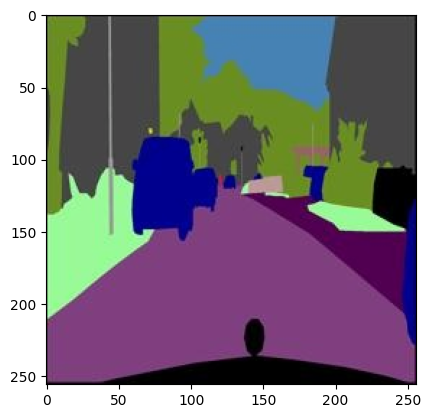

In [7]:
batch = next(iter(train_loader))
plt.imshow(de_normalize_b(batch[1][0]).numpy())
plt.show()

## Training

In [ ]:
devices = [7]

In [3]:
# def create_argparser():
#     defaults = dict(
#         data_dir="",
#         dataset='edges2handbags',
#         schedule_sampler="uniform",
#         lr=1e-4,
#         weight_decay=0.0,
#         lr_anneal_steps=0,
#         global_batch_size=2048,
#         batch_size=-1,
#         microbatch=-1,  # -1 disables microbatches
#         ema_rate="0.9999",  # comma-separated list of EMA values
#         log_interval=50,
#         test_interval=500,
#         save_interval=10000,
#         save_interval_for_preemption=50000,
#         resume_checkpoint="",
#         exp='',
#         use_fp16=False,
#         fp16_scale_growth=1e-3,
#         debug=False,
#         num_workers=2,
#         use_augment=False
#     )
#     defaults.update(model_and_diffusion_defaults())
#     parser = argparse.ArgumentParser()
#     add_dict_to_argparser(parser, defaults)
#     return parser


# args = create_argparser().parse_args()

In [ ]:
"""
Train a diffusion model on images.
"""


def main(args):

    workdir = get_workdir(args.exp)
    Path(workdir).mkdir(parents=True, exist_ok=True)
    
    dist_util.setup_dist(devices=devices)
    logger.configure(dir=workdir)
    if dist.get_rank() == 0:
        name = args.exp if args.resume_checkpoint == "" else args.exp + '_resume'
        wandb.init(project="bridge", group=args.exp,name=name, config=vars(args), mode='online' if not args.debug else 'disabled')
        logger.log("creating model and diffusion...")
    

    data_image_size = args.image_size
    

    if args.resume_checkpoint == "":
        model_ckpts = list(glob(f'{workdir}/*model*[0-9].*'))
        if len(model_ckpts) > 0:
            max_ckpt = max(model_ckpts, key=lambda x: int(x.split('model_')[-1].split('.')[0]))
            if os.path.exists(max_ckpt):
                args.resume_checkpoint = max_ckpt
                if dist.get_rank() == 0:
                    logger.log('Resuming from checkpoint: ', max_ckpt)


    model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )
    model.to(dist_util.dev())

    if dist.get_rank() == 0:
        wandb.watch(model, log='all')
    schedule_sampler = create_named_schedule_sampler(args.schedule_sampler, diffusion)

    
    if args.batch_size == -1:
        batch_size = args.global_batch_size // dist.get_world_size()
        if args.global_batch_size % dist.get_world_size() != 0:
            logger.log(
                f"warning, using smaller global_batch_size of {dist.get_world_size()*batch_size} instead of {args.global_batch_size}"
            )
    else:
        batch_size = args.batch_size
        
    if dist.get_rank() == 0:
        logger.log("creating data loader...")

    data, test_data = load_data(
        data_dir=args.data_dir,
        dataset=args.dataset,
        batch_size=batch_size,
        image_size=data_image_size,
        num_workers=args.num_workers,
    )
    
    if args.use_augment:
        augment = AugmentPipe(
                p=0.12,xflip=1e8, yflip=1, scale=1, rotate_frac=1, aniso=1, translate_frac=1
            )
    else:
        augment = None
        
    logger.log("training...")
    TrainLoop(
        model=model,
        diffusion=diffusion,
        train_data=data,
        test_data=test_data,
        batch_size=batch_size,
        microbatch=args.microbatch,
        lr=args.lr,
        ema_rate=args.ema_rate,
        log_interval=args.log_interval,
        test_interval=args.test_interval,
        save_interval=args.save_interval,
        save_interval_for_preemption=args.save_interval_for_preemption,
        resume_checkpoint=args.resume_checkpoint,
        workdir=workdir,
        use_fp16=args.use_fp16,
        fp16_scale_growth=args.fp16_scale_growth,
        schedule_sampler=schedule_sampler,
        weight_decay=args.weight_decay,
        lr_anneal_steps=args.lr_anneal_steps,
        augment_pipe=augment,
        **sample_defaults()
    ).run_loop()
